In [3]:
# 3L_SDVRP 


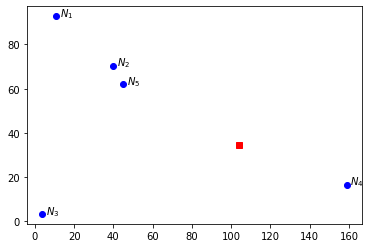

In [161]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multinomial
from scipy.stats import dirichlet
from py3dbp import Packer, Bin, Item


# "rnd" is an object that generate random numbers
rnd = np.random
#"seed(0)" is a method that reset (every time), the same random set of numbers
rnd.seed(0)
# Number of collection points
n_customer = 5
# The set of nodes without the depot.
N = [i for i in range(1,n_customer+1)]
# The set of nodes + the depot.
V = [0]+ N
# The Number of cargoes
Cat = 10
# Generating items for each collection point
IT = []
for i in N:
    cargo_set_=[]
    for j in range (0,Cat):
        cargo_set_.append({(i,j):[rnd.randint(1, kk) for kk in [10,10,10,100]]})
    IT.append(cargo_set_)
# Number of Vehicles
nv = 3
# Max volume and Max weight that each vehicle can carry
Container_vehicle = [('vehicle_%d'%kk, rnd.randint(30, 50), rnd.randint(30, 50), rnd.randint(30, 50), rnd.randint(100, 500)) for kk in range(0,nv) ]
# Generating random numbers between (0 and 15) * 200.
xc = rnd.rand(n_customer+1)*200
# Generating random numbers between (0 and 15) * 100.
yc = rnd.rand(n_customer+1)*100
# The number of Routing plans
RP = 10
#Plotting the n nodes without the node 0 (depot) and chose the color blue for each node.
plt.scatter(xc[1:],yc[1:],c='b')
# Associating and plotting each demand in the right of each blue node (customer).
for i in N:
    plt.annotate('$N_%d$'%(i),(xc[i]+2,yc[i]))
# Ploting the node 0, chosing the red like its color and the square form like a marker.
plt.plot(xc[0],yc[0],c='r' ,marker='s')
# Showing the Initial plot.
plt.show()
# Intializing the set of arcs A.
A = [(i,j) for i in V for j in V if i!=j]
# Calculating the distance between each node as non-negative cost of each arc
dist= {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in A}
# Generating historical data wich show how many times each route has been chosen
historical_routes = [rnd.randint(1, 100) for i in range(0, len(A))]

In [151]:
import dirichlet
help(dirichlet)
dirichlet.meanprecision(np.array(historical_routes))
dirichlet.mle(np.array(10,5), tol=1e-07, method='meanprecision', maxiter=None)

In [152]:
# Vehicle Route Planning Module

# alpha = np.array(historical_routes) # alpha is an array of our historical data for each edge

def findRoutPlans(alpha):

    drichlet_mean = dirichlet.mean(alpha)
    multinomial_ed = multinomial.rvs(300, drichlet_mean, size=RP*2)

    # Finding Edges
    semi_final_path = []
    for routplansiterator in range(0, len(multinomial_ed)):
        sorted_edges=[]
        for maxifinder in range(max(multinomial_ed[routplansiterator]), -1, -1):
            finded = np.where(multinomial_ed[routplansiterator] == maxifinder)
            sorted_edges.append(finded[0])

        first_path = []
        for hh in sorted_edges:
            for ff in hh:
                # Checking for duplicate collection points
                if len(first_path)>0:
                    first_elements = [i for i,j in first_path]
                    second_elements = [j for i,j in first_path]
                    if A[ff][0] not in first_elements and A[ff][1] not in second_elements:
                        first_path.append(A[ff])
                else:
                    first_path.append(A[ff])
                    
        semi_final_path.append(first_path[0:n_customer])
    
    # Removing invalids
    numfailed = []
    for rpiterator in range(0,len(semi_final_path)):
        starting_point=0
        for jkl in semi_final_path[rpiterator]:
            starting_point=starting_point+1
            for lkj in semi_final_path[rpiterator][starting_point:]:
                if (jkl[1] == lkj[0] and jkl[0] == lkj[1]):
                    numfailed.append(rpiterator)
                    
    final_path = [i for n, i in enumerate(semi_final_path) if n not in numfailed]
    
    return final_path


In [153]:
# Collection points that vehicle should pass

def collectionPointsFinder(final_path):

    allocatedCPs=[]
    CPs=[]

    for y in range(0,len(final_path)):
        for i, j in final_path[y]:
            CPs.append(i)
            CPs.append(j)
        allocatedCPs.append(set(myset))
        
    return allocatedCPs


In [154]:
# Splitting Module

# Sorting
def splitCargoes(alpha_s, nv):
    drichlet_mean_s = dirichlet.mean(alpha_s)

    multinomial_ed_s = multinomial.rvs(100, drichlet_mean_s, size=5)

    # Choosing Cargoes
    final_set = []
    
    for cargoewclassiterator in range(0, len(multinomial_ed_s)):
        sorted_cargoes=[]
        for maxfinder in range(max(multinomial_ed_s[cargoewclassiterator]), -1, -1):
            if maxfinder>0:
                finded_cargoes = np.where(multinomial_ed_s[cargoewclassiterator] == maxfinder)
                sorted_cargoes.append(finded_cargoes[0])

        first_set = []
        for hh in sorted_cargoes:
            for ff in hh:
                first_set.append(IT[cargoewclassiterator][ff])

        final_set.append([first_set])

    # Cargoes for vehicles
    set_for_vehicles=[]
    
    for vehicle_num in range(0,nv):
        init_set=[]
        
        for custom_num in range(0,n_customer):
            init_set.append(final_set[custom_num][0][vehicle_num*round(Cat/nv):vehicle_num*round(Cat/nv)+round(Cat/nv)])
        set_for_vehicles.append(init_set)

    return set_for_vehicles, final_set

In [155]:
# Optimal 3D Loading Module

def loading(Container_vehicle, final_set):

    packer = Packer()
    # The maximum volum and weight that a container can carry (length, width, height, weight)
    # for vehicle_name, vehicle_width, vehicle_height, vehicle_depth, vehicle_weight in Container_vehicle:
        # Add bins Number of vehicles
        # packer.add_bin(Bin(vehicle_name, vehicle_width, vehicle_height, vehicle_depth, vehicle_weight)) 
    packer.add_bin(Bin(Container_vehicle[0],
                        Container_vehicle[1],
                        Container_vehicle[2],
                        Container_vehicle[3],
                        Container_vehicle[4]))

    # add corresponding items to containers
    for customeritems in final_set:
        for items in customeritems:
            # for boxes in items:
            packer.add_item(Item(list(items.keys())[0],
                                list(items.values())[0][0],
                                list(items.values())[0][1],
                                list(items.values())[0][2],
                                list(items.values())[0][3]))

    packer.pack(number_of_decimals=0)

    # for b in packer.bins:
    #     print(":::::::::::", b.string())

    #     print("FITTED ITEMS:")
    #     for item in b.items:
    #         print("====> ", item.string())

    #     print("UNFITTED ITEMS:")
    #     for item in b.unfitted_items:
    #         print("====> ", item.string())

    #     print("**************************")

    return packer

In [182]:
# Fitness Function 1
def fitnessFunction_1(pop):
# F1=[]
# for pop in init_pop_route:
    F1=[]
    for vehicles in range(0, len(pop)):
        route_cost = 0
        for i in pop[vehicles]:
            route_cost = route_cost + dist[i]
        F1.append(route_cost)
    return sum(F1)
    # F1.append(sum(F1_init))

In [244]:
# Fitness Function 2

def fitnessFunction_2(pc_items, pc_bins):

    # Calculate each container capacity
    containers_weight = [wgh[4] for wgh in Container_vehicle]
    containers_volume = [vol[1]*vol[2]*vol[3] for vol in Container_vehicle]

    # Calculate all items wgh and vol
    items_weight = []
    items_volume = []

    for boxes in pc_items:
        items_weight.append([item.weight for item in boxes])
        items_volume.append([item.get_volume() for item in boxes])

    total_items_weight = np.array(items_weight)
    total_items_volume = np.array(items_volume)

    rvol_mean = np.sum(total_items_volume)/sum(containers_volume)
    rwgh_mean = np.sum(total_items_weight)/sum(containers_weight)

    # Calculate each vehicle bins items wgh and vol
    bins_fitteditems_weight = []
    bins_fitteditems_volume = []

    for contain in pc_bins:
        bins_fitteditems_weight.append([item.weight for item in contain[0].items])
        bins_fitteditems_volume.append([item.get_volume() for item in contain[0].items])
    fitted_items_weight = np.array(bins_fitteditems_weight)
    fitted_items_volume = np.array(bins_fitteditems_volume)

    total_fitteditems_wgh = sum(np.sum(fitted_items_weight))
    total_fitteditems_vol = sum(np.sum(fitted_items_volume))

    F2 = 1000000 - (abs(total_fitteditems_vol - total_fitteditems_wgh) - (total_fitteditems_vol + total_fitteditems_wgh))

    return F2

In [245]:
# Init Population for NSGA_II

alpha = np.array(historical_routes)

one_prob = [1 for i in range(0, len(IT[0]))]
alpha_s = np.array(one_prob)

init_pop_route = []
init_pop_set = []
init_pop_pack_bins = []
init_pop_pack_items = []

pop_size = 10
pop = {}
for ind in range(0,pop_size):
    final_path = findRoutPlans(alpha)
    set_per_vehic, total_sets = splitCargoes(alpha_s, nv)
    
    pc_bins = []
    pc_items = []
    counter_sets = 0

    for vehicle_count in range(0,len(Container_vehicle)):
        pc = loading(Container_vehicle[vehicle_count], set_per_vehic[counter_sets])
        pc_bins.append(pc.bins)
        pc_items.append(pc.items)
        counter_sets = counter_sets + 1

    init_pop_route.append(final_path[0:len(Container_vehicle)])
    init_pop_set.append(set_per_vehic)
    init_pop_pack_bins.append(pc_bins)
    init_pop_pack_items.append(pc_items)

    fitness_1 = fitnessFunction_1(final_path[0:len(Container_vehicle)])
    fitness_2 = fitnessFunction_2(pc_items, pc_bins)

    pop[ind] = {'route': final_path[0:len(Container_vehicle)],
                'set': set_per_vehic,
                'pack_bins': pc_bins,
                'pack_items': pc_items,
                'F1': fitness_1,
                'F2': fitness_2
                } 


In [239]:
#Function to find index of list
def index_of(a,list):
    for i in range(0,len(list)):
        if list[i] == a:
            return i
    return -1

In [240]:
#Function to sort by values
def sort_by_values(list1, values):
    sorted_list = []
    while(len(sorted_list)!=len(list1)):
        if index_of(min(values),values) in list1:
            sorted_list.append(index_of(min(values),values))
        values[index_of(min(values),values)] = math.inf
    return sorted_list

In [241]:
#Function to calculate crowding distance
def crowding_distance(values1, values2, front):
    distance = [0 for i in range(0,len(front))]
    sorted1 = sort_by_values(front, values1[:])
    sorted2 = sort_by_values(front, values2[:])
    distance[0] = 4444444444444444
    distance[len(front) - 1] = 4444444444444444
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted1[k+1]] - values2[sorted1[k-1]])/(max(values1)-min(values1))
    for k in range(1,len(front)-1):
        distance[k] = distance[k]+ (values1[sorted2[k+1]] - values2[sorted2[k-1]])/(max(values2)-min(values2))
    return distance

In [237]:
#Function to carry out NSGA-II's fast non dominated sort
def fast_non_dominated_sort(values1, values2):
    S=[[] for i in range(0,len(values1))]
    front = [[]]
    n=[0 for i in range(0,len(values1))]
    rank = [0 for i in range(0, len(values1))]

    for p in range(0,len(values1)):
        S[p]=[]
        n[p]=0
        for q in range(0, len(values1)):
            if (values1[p] > values1[q] and values2[p] > values2[q]) or (values1[p] >= values1[q] and values2[p] > values2[q]) or (values1[p] > values1[q] and values2[p] >= values2[q]):
                if q not in S[p]:
                    S[p].append(q)
            elif (values1[q] > values1[p] and values2[q] > values2[p]) or (values1[q] >= values1[p] and values2[q] > values2[p]) or (values1[q] > values1[p] and values2[q] >= values2[p]):
                n[p] = n[p] + 1
        if n[p]==0:
            rank[p] = 0
            if p not in front[0]:
                front[0].append(p)

    i = 0
    while(front[i] != []):
        Q=[]
        for p in front[i]:
            for q in S[p]:
                n[q] =n[q] - 1
                if( n[q]==0):
                    rank[q]=i+1
                    if q not in Q:
                        Q.append(q)
        i = i+1
        front.append(Q)

    del front[len(front)-1]
    return front

In [246]:
objective1_values = [pop[i]['F1'] for i in range(0,len(pop))]
objective2_values = [pop[i]['F2'] for i in range(0,len(pop))]
objective2_values


[Decimal('1002108'),
 Decimal('1002102'),
 Decimal('1002100'),
 Decimal('1002088'),
 Decimal('1002042'),
 Decimal('1002128'),
 Decimal('1002124'),
 Decimal('1002086'),
 Decimal('1002082'),
 Decimal('1002078')]

In [247]:
objective1_values

[1343.2283274084193,
 1410.7555567748427,
 1349.1574060123248,
 1488.570022349446,
 1370.7308455827647,
 1226.7625916843356,
 1017.2539573257343,
 1333.9672170913116,
 1430.8820628254236,
 1304.382514387584]

In [249]:
non_dominated_sorted_solution = non_dominated_sorting_algorithm(objective1_values[:],objective2_values[:])
non_dominated_sorted_solution
print('Best Front for Generation:',1)
for values in non_dominated_sorted_solution[0]:
    print(pop[values]['F1'],pop[values]['F2'] ,end=" ")
print("\n")
crowding_distance_values=[]
for i in range(0,len(non_dominated_sorted_solution)):
        crowding_distance_values.append(crowding_distance(objective1_values[:],
                                        objective2_values[:],
                                        non_dominated_sorted_solution[i][:]))
solution2 = solution[:]

Best Front for Generation: 1
1343.2283274084193 1002108 1410.7555567748427 1002102 1488.570022349446 1002088 1226.7625916843356 1002128 



TypeError: unsupported operand type(s) for -: 'float' and 'decimal.Decimal'

In [169]:
# LP minimization module

from mip import CBC
from mip import Model, xsum, minimize, BINARY, maximize
Sload = 10
Qload = 10
s = [6, 2, 3, 4, 10, 4]
q = [10, 5, 6, 1, 8, 8]
A = len(q)
model = Model(sense = maximize, solver_name = CBC)
p = [model.add_var() for k in range(0, A)]
model.objective = maximize(xsum((s[k] + q[k]) * p[k] for k in range(0, A)))

model += xsum(s[k] * p[k] for k in range(0, A)) <=Sload
model += xsum(q[k] * p[k] for k in range(0, A)) <=Qload
for k in range(0, A):
    model += p[k] <=1
model.optimize(max_seconds = 300)
status = model.optimize()
print(status)
for k in range(0, A):
    print(p[k].x)


In [224]:
# %matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
import math

In [227]:
class MOO_Problem():
    '''
    Class defines the dfferent constraint function that are needed to be minimized.
    Param:
        d: Dimension of input vector for the constraint functions
        lower: (mx1) numpy array giving lower bound of the m constraints. Default = -1
        upper: (mx1) numpy array giving upper bound of the m constraints. Default = 1
        *args: m constraints in the form of python functions capable of running on (Nxd) numpy arrays
    Usage: MOO_Problem(func1, func2, func3, ...)
    '''
    def __init__(self, *args, d=None,lower=None, upper=None):
        if d is None:
            print("Missing required parameter 'd'")
            sys.exit(-1)
        self.d = d
        self.m = len(args)
        if self.m < 1:
            print("Enter atleast one constraint function")
            sys.exit(-1)
        self.constraints = list(args)
        self.lower = lower if lower is not None else -np.ones((1, self.d))
        self.upper = upper if upper is not None else np.ones((1, self.d))
    
    def evaluate(self, x):
        '''
        Evaluate the constriants on multiple possible vectors
        Param: x: (N, m) numpy matrix where N is number of vectors and m is number of constraints
        Return: (N, m) numpy array of evaluated results
        '''
        N = x.shape[0]
        obj = np.empty((N, self.m))
        for i in range(self.m):
            obj[:, i] = np.squeeze(self.constraints[i](x))
        return obj

In [228]:
class NSGAII():
    '''
    Class to run the NSGA II algorithm
    '''
    def __init__(self, moo_problem, pop_size=100 , p_mutate=1.0, p_crossover=1.0, n_iter=100, max_evals= 100*500, initial_pop=None):
        '''
        Param:
            moo_problem: Multi objective problem of class MOO_Problem
            pop_size: Number of individuals to maintain in each iteration
            p_mutate: probability of mutation (between 0 and 1, default 1)
            p_crossover: probabilty of crossover (between 0 and 1, default 1)
            n_iter: Maximum number of iterations allowed (default = 100)
            max_evals: Maximum number of function evaluations allowed (default = 500 per individual)
            initial_pop: (Nxd) numpy array of initial population of individuals. If None then randomly initialized
        '''
        self.N = pop_size
        self.p_m = p_mutate
        self.p_c = p_crossover
        self.max_iter = n_iter
        self.max_evals = max_evals
        self.moo = moo_problem
        if initial_pop is not None and initial_pop.shape[1]==self.moo.d:
            self.pop = [initial_pop, self.moo.evaluate(initial_pop)]
        else:
            if initial_pop is not None:
                print("Initial population passed has wrong dimensions. Initializing random population...")
            random_pop = np.random.random((self.N, self.moo.d)) * (self.moo.upper - self.moo.lower) + self.moo.lower
            self.pop = [random_pop, self.moo.evaluate(random_pop)]            

    def non_dominated_sort(self, n_sort=None):
        '''
        Performs non dominated sort of the population in this iteration
        Param: n_sort: maximum number of individuals to sort
        Return:
            front_ids: (Nx1) vctor where front_id[i] is the front number of pop[i]
            max_front: Number of fronts calculated
        '''
        # Initialization
        pop_cost = self.pop[1]
        N = pop_cost.shape[0]
        _, loc = np.unique(pop_cost[:,0], return_inverse=True)
        if n_sort is None: n_sort = len(loc)
        sorted_cost = pop_cost[pop_cost[:,0].argsort(), :]
        front_id = np.inf*np.ones(N)
        max_front = 0
        #Non dominated sort
        while np.sum(front_id < np.inf) < n_sort:      # while individuals left without front_id
            max_front += 1
            for i in np.where(front_id==np.inf)[0]:
#                 if np.sum(front_id < np.inf) >= n_sort: break
                dominated = False
                for j in range(i, 0, -1):
                    if front_id[j-1] == max_front:
                        m=2
                        while(m<=self.moo.m) and (sorted_cost[i, m-1] >= sorted_cost[j-1, m-1]):
                            m += 1
                        dominated = m > self.moo.m
                        if dominated or self.moo.m==2:
                            break
                if not dominated:
                    front_id[i] = max_front
        return front_id[loc], max_front
        
    def crowding_distance(self, front_id):
        '''
        Calculate the crowding distance for each pareto front
        Param: front_id: (Nx1) numpy array where front_i[i] is the front number for pop[i]
        Return: crowd_dis: (Nx1) numpy array of crowding distances
        '''
        N = self.pop[0].shape[0]
        pop_cost = self.pop[1]
        crowd_dis = np.zeros(N)
        fronts = np.unique(front_id)
        fronts = fronts[fronts!=np.inf]
        
        for f in range(len(fronts)):
            front = np.where(front_id==f+1)[0]
            fmax = np.max(pop_cost[front, :], axis=0)
            fmin = np.min(pop_cost[front, :], axis=0)
            for i in range(self.moo.m):
                rank = np.argsort(pop_cost[front, i])
                crowd_dis[front[rank[0]]] = np.inf
                crowd_dis[front[rank[-1]]] = np.inf
                for j in range(1, len(front)-1):
                    crowd_dis[front[rank[j]]] = crowd_dis[front[rank[j]]] + \
                            (pop_cost[front[rank[j+1]], i] - pop_cost[front[rank[j-1]], i]) / (fmax[i]-fmin[i])
        return crowd_dis
    
    def tournament(self, fit, K=2):
        '''
        Perform crowded tournament
        Param:
            K: Number of parameters to be considered for fitness
            fit: (N, K) matrix of fitness values, where the higher column means higher preference
        Return: indices of individuals who won the tournament
        '''
        n_total = len(fit)
        a = np.random.randint(n_total, size=self.N)
        b = np.random.randint(n_total, size=(self.N, K))
        for i in range(self.N):
            for j in range(K):
                for r in range(fit[0, :].size):
                    if fit[b[i, j], r] < fit[a[i], r]:
                        a[i] = b[i,j]
        return a
    
    def evolve(self, parents, boundary=None):
        ''' Creates the offspring from parents through crossover + mutation
        Param:
            parents: (Nxm) matrix of parents to participate in mutation
            boundary: (lower, upper) bounds of the constraints. Defualt value taken from moo problem.
        '''
        dis_c, dis_m = 20, 20
        parents = parents[:(len(parents)//2)*2, :]
        (n, d) = parents.shape
        parent_1, parent_2 = parents[:n//2, :], parents[n//2:, :]
        
        ## CROSSOVER
        beta = np.empty((n//2, d))
        mu = np.random.random((n//2, d))
        beta[mu <= 0.5]= np.power(2 * mu[mu <= 0.5], 1 / (dis_c + 1))
        beta[mu > 0.5] = np.power(2 * mu[mu > 0.5], -1 / (dis_c + 1))
        beta = beta * ((-1)** np.random.randint(2, size=(n // 2, d)))
        beta[np.random.random((n // 2, d)) < 0.5] = 1
        beta[np.tile(np.random.random((n // 2, 1)) > self.p_c, (1, d))] = 1
        # beta=1 means no crossover
        
        offspring = np.vstack(((parent_1 + parent_2) / 2 + beta * (parent_1 - parent_2) / 2,
                                   (parent_1 + parent_2) / 2 - beta * (parent_1 - parent_2) / 2))

        ## MUTATION
        site = np.random.random((n, d)) < self.p_m / d
        mu = np.random.random((n, d))
        temp = site & (mu <= 0.5)
        if boundary is None:
            lower, upper = np.tile(self.moo.lower, (n, 1)), np.tile(self.moo.upper, (n,1))
        else:
            lower, upper = boundary
        norm = (offspring[temp] - lower[temp]) / (upper[temp] - lower[temp])
        offspring[temp] += (upper[temp] - lower[temp]) * \
                               (np.power(2. * mu[temp] + (1. - 2. * mu[temp]) * np.power(1. - norm, dis_m + 1.),
                                         1. / (dis_m + 1)) - 1.)
        temp = ~temp
        norm = (upper[temp] - offspring[temp]) / (upper[temp] - lower[temp])
        offspring[temp] += (upper[temp] - lower[temp])* \
                               (1. - np.power(
                                   2. * (1. - mu[temp]) + 2. * (mu[temp] - 0.5) * np.power(1. - norm, dis_m + 1.),
                                   1. / (dis_m + 1.)))
        offspring = np.maximum(np.minimum(offspring, upper), lower)
        return offspring
    
    def selection(self):
        '''Performs the environment selection based on the front_ids and crowding_distance
        '''
        front_id, max_front = self.non_dominated_sort(n_sort=self.N)
        next_label = np.zeros(front_id.shape[0], dtype=bool)
        next_label[front_id<max_front] = True
        crowd_dis = self.crowding_distance(front_id)
        last = np.where(front_id==max_front)[0]
        rank = np.argsort(-crowd_dis[last])
        delta_n = rank[:(self.N - int(np.sum(next_label)))]
        next_label[last[delta_n]] = True
        index = np.where(next_label)[0]
        self.pop = [self.pop[0][index, :], self.pop[1][index, :]]
        return front_id[index], crowd_dis[index], index
    
    def run(self):
        front_id, max_front = self.non_dominated_sort()
        crowd_dis = self.crowding_distance(front_id)
        
        eval_left, n_iter = self.max_evals, 0
        while eval_left >= 0 and n_iter <= self.max_iter:
            fit = np.vstack((front_id, crowd_dis)).T
            mating_pool = self.tournament(fit)
            parent = [self.pop[0][mating_pool, :], self.pop[1][mating_pool, :]]
            offspring = self.evolve(parent[0])
            offspring_cost = self.moo.evaluate(offspring)
            self.pop = [np.vstack((self.pop[0], offspring)), np.vstack((self.pop[1], offspring_cost))]
            front_id, crowd_dis, _ = self.selection()
            eval_left -= self.N
            n_iter +=1
                
        print("Num iteration: {}, Num. function evaluations: {}".format(n_iter, self.max_evals-eval_left))
        return self.pop
        
    def visualize(self):
        _ = self.run()
        pop_cost = self.pop[1]
        front_id, max_front = self.non_dominated_sort()
        non_dominated = pop_cost[front_id==1, :]
        if self.moo.m == 2:
            ax = plt.subplot(111)
            ax.scatter(non_dominated[:, 0], non_dominated[:, 1])
        elif self.moo.m == 3:
            x, y, z = non_dominated[:, 0], non_dominated[:, 1], non_dominated[:, 2]
            ax = plt.subplot(111, projection='3d')
            norm =  (non_dominated - non_dominated.min(0)) / non_dominated.ptp(0)
            ax.scatter(x, y, z, c=norm)
        else:
            
            for i in range(len(non_dominated)):
                ax = plt.subplot(3,len(non_dominated)//3+1, i)
                ax.plot(range(1, self.moo.m + 1), non_dominated[i, :])
        return ax